# 引入库

In [1]:
#引入库
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as image
import cv2
import time
import os

# model

In [2]:
#model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution layer 1
        self.conv1 = nn.Conv2d(in_channels = 1 , out_channels = 64, kernel_size = 5, stride = 1, padding = 2 )
        self.relu1 = nn.ReLU()
        self.batch1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(in_channels =64 , out_channels = 64, kernel_size = 5, stride = 1, padding = 2 )
        self.relu2 = nn.ReLU()
        self.batch2 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.drop1 = nn.Dropout(0.25)

        # Convolution layer 2
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1 )
        self.relu3 = nn.ReLU()
        self.batch3 = nn.BatchNorm2d(64)
        
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1 )
        self.relu4 = nn.ReLU()
        self.batch4 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.drop2 = nn.Dropout(0.25)
        
        self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1 )
        self.relu5 = nn.ReLU()
        self.batch5 = nn.BatchNorm2d(64)
        self.drop3 = nn.Dropout(0.25)
        
        # Fully-Connected layer 1
        
        self.fc1 = nn.Linear(3136,256)
        self.fc1_relu = nn.ReLU()
        self.batch5 = nn.BatchNorm2d(64)
        self.dp1 = nn.Dropout(0.25)
        
        # Fully-Connected layer 2
        self.fc2 = nn.Linear(256,10)
        
        '''
        ###############################################
        # Reinitialize weights using He initialization
        ###############################################
        for m in self.modules():
             if isinstance(m, nn.Conv2d):
                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
             elif isinstance(m, nn.BatchNorm2d):
                 nn.init.constant_(m.weight, 1)
                 nn.init.constant_(m.bias, 0)
             elif isinstance(m, nn.Linear):
                 nn.init.xavier_normal_(m.weight)
                 nn.init.constant_(m.bias, 0)
        '''
                
    def forward(self, x):
        # conv layer 1 的前向计算，3行代码
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.batch1(out)
        
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.batch2(out)
        
        out = self.maxpool1(out)
        out = self.drop1(out)

        # conv layer 2 的前向计算，4行代码
        out = self.conv3(out)
        out = self.relu3(out)
        out = self.batch3(out)
        
        out = self.conv4(out)
        out = self.relu4(out)
        out = self.batch4(out)
        
        out = self.maxpool2(out)
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.relu5(out)
        out = self.batch5(out)
        out = self.drop3(out)

        #Flatten拉平操作
        out = out.view(out.size(0),-1)

        #FC layer的前向计算（2行代码）
        out = self.fc1(out)
        out = self.fc1_relu(out)
        out = self.dp1(out)
        
        out = self.fc2(out)

        return F.log_softmax(out,dim = 1)

# 实例化并加载模型

In [3]:
#实例化模型
network = CNNModel()

#加载模型
model_path = "./model03.pth"
network.load_state_dict(torch.load(model_path))
network.eval()

CNNModel(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (batch4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.

# 图片处理

In [4]:
#图片处理
def imageProcess(img):
    #处理图片
    data_transform = torchvision.transforms.Compose(
        [torchvision.transforms.Resize(32),
         torchvision.transforms.CenterCrop(28),
         torchvision.transforms.ToTensor(),
         torchvision.transforms.Normalize((0.1307,), (0.3081,))])
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)# 灰度处理
    retval, dst = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)# 二值化
    fanse = cv2.bitwise_not(dst)#黑白反转

    #将BGR图像转变成RGB图像：即将cv2.imread转换成Image.open
    imgs = Image.fromarray(cv2.cvtColor(fanse, cv2.COLOR_BGR2RGB))
    imgs = imgs.convert('L') #将三通道图像转换成单通道灰度图像
    imgs = data_transform(imgs)#处理图像
    
    return imgs

# 预测单张手写数字图片

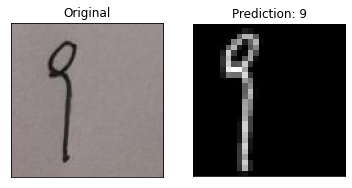

In [5]:
#预测单张手写数字图片
path = 'E:/jupyter_notebook/test/'
with torch.no_grad():   
    img = cv2.imread(path + '9_3.jpg')#预测图片
    imgs = imageProcess(img)
    if imgs.shape == torch.Size([1,28,28]):
        imgs = torch.unsqueeze(imgs, dim=0) #在最前面增加一个维度
    output = network(imgs)
    plt.tight_layout()
    plt.subplot(121)
    img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.imshow(img)
    plt.title("Original")
    plt.xticks([])
    plt.yticks([])

    
    plt.subplot(122)
    plt.imshow(imgs[0][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(output.data.max(dim = 1, keepdim=True)[1].item()))
    plt.xticks([])
    plt.yticks([])
    plt.show()

# 预测多张手写数字图片

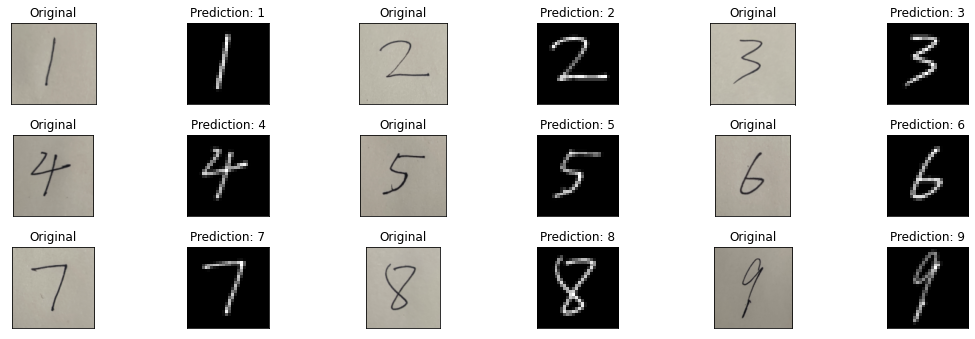

In [6]:
#预测多张手写数字图片
with torch.no_grad():  
    fig = plt.figure(figsize=(15,5))
    
    for i in range(9):
        img = cv2.imread(path + str(i+1) + ".jpg")#预测图片
        imgs =  imageProcess(img)
        if imgs.shape == torch.Size([1,28,28]):
            imgs = torch.unsqueeze(imgs, dim=0)
        output = network(imgs)
        ax1 = fig.add_subplot(3,6,2*i+1)
        img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.imshow(img)
        plt.title("Original")
        plt.xticks([])
        plt.yticks([])
        
        plt.subplot(3,6,2*i+2)
        plt.tight_layout()
        plt.imshow(imgs[0][0], cmap='gray', interpolation='none')
        plt.title("Prediction: {}".format(
        output.data.max(dim = 1, keepdim=True)[1].item()))
        plt.xticks([])
        plt.yticks([])
    plt.show()